In [67]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [68]:
# !cp '/content/drive/MyDrive/spectrograms.zip' .

In [69]:
# !unzip -q spectrograms.zip

In [70]:
# !pip list

In [71]:
# !rm -r /content/logs

In [72]:
import keras.callbacks
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import math
import pandas as pd
import random
from tensorflow.keras import models, layers, callbacks, activations

import librosa
import librosa.display

import warnings

import pickle

AUTOTUNE = tf.data.AUTOTUNE

# tf.config.run_functions_eagerly(True)

In [73]:
SAMPLE_RATE = 24000
FREQ_SIZE = 188
SECONDS = 4

N_MFCC = 100

BATCH_SIZE_TRAIN = 25
BATCH_SIZE_TEST = 1
BATCH_SIZE_VAL = 50
EPOCHS = 75

NUM_TRAIN = 1125
NUM_VAL = 500
NUM_TEST = 250

STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE_TRAIN

# LABELS_FR = ['zéro','un','deux','trois','quatre','cinq','six','sept','huit','neuf','dix','Hey','oui','non','Firefox']

# NUM_LABELS_FR = len(LABELS_FR)
NUM_LANGUAGES = 1
LANGUAGES = ['EN','ES','FR','DE']

LOG_DIR = "/content/logs/model" + str(NUM_LANGUAGES) + "-"

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

LEARNING_RATE = 0.0001

In [74]:
BASE_DIR_EN = '/content/spectrograms/en/clips/'
TRAIN_PATH_EN = '/content/spectrograms/en/train.tsv'
TEST_PATH_EN = '/content/spectrograms/en/test.tsv'
VAL_PATH_EN = '/content/spectrograms/en/val.tsv'

NUM_TRAIN_EN = NUM_TRAIN
NUM_VAL_EN = NUM_VAL
NUM_TEST_EN = NUM_TEST

LABELS_EN = ['zero','one','two','three','four','five','six','seven','eight','nine','ten','Hey','yes','no','Firefox']
NUM_LABELS_EN = len(LABELS_EN)

In [75]:
BASE_DIR_ES = '/content/spectrograms/es/clips/'
TRAIN_PATH_ES = '/content/spectrograms/es/train.tsv'
TEST_PATH_ES = '/content/spectrograms/es/test.tsv'
VAL_PATH_ES = '/content/spectrograms/es/val.tsv'

NUM_TRAIN_ES = NUM_TRAIN
NUM_VAL_ES = NUM_VAL
NUM_TEST_ES = NUM_TEST

LABELS_ES = ['cero','cinco','cuatro','dos','Firefox','Hey','no','neuve','ocho','seis','siete','tres','uno','sí']
NUM_LABELS_ES = len(LABELS_ES)

In [76]:
BASE_DIR_FR = '/content/spectrograms/fr/clips/'
TRAIN_PATH_FR = '/content/spectrograms/fr/train.tsv'
TEST_PATH_FR = '/content/spectrograms/fr/test.tsv'
VAL_PATH_FR = '/content/spectrograms/fr/val.tsv'

NUM_TRAIN_FR = NUM_TRAIN
NUM_VAL_FR = NUM_VAL
NUM_TEST_FR = NUM_TEST

LABELS_FR = ['zéro','un','deux','trois','quatre','cinq','six','sept','huit','neuf','dix','Hey','oui','non','Firefox']
NUM_LABELS_FR = len(LABELS_FR)

In [77]:
BASE_DIR_DE = '/content/spectrograms/de/clips/'
TRAIN_PATH_DE = '/content/spectrograms/de/train.tsv'
TEST_PATH_DE = '/content/spectrograms/de/test.tsv'
VAL_PATH_DE = '/content/spectrograms/de/val.tsv'

NUM_TRAIN_DE = NUM_TRAIN
NUM_VAL_DE = NUM_VAL
NUM_TEST_DE = NUM_TEST

LABELS_DE = ['zwei','vier','sieben','sechs','neun','nein','nan','ja','fünf','eins','drei','acht','Hey','Hei','Firefox']
NUM_LABELS_DE = len(LABELS_DE)

In [78]:
def padaudio(waveform):
    if (len(waveform) >= SAMPLE_RATE * SECONDS):
        return waveform
    else:
        return np.pad(waveform,(0,SAMPLE_RATE * SECONDS - len(waveform)),mode='constant', constant_values=(0,0))

# def processdata(file):
#     waveform,sample_rate = librosa.load(file, SAMPLE_RATE)
#     waveform = padaudio(waveform)
#     mfccs = librosa.feature.mfcc(waveform,sr=sample_rate,n_mfcc=N_MFCC)
#     mfccs = np.moveaxis(mfccs,1,0)
#     scaler = StandardScaler()
#     mfccs_scaled = scaler.fit_transform(mfccs)
#     return mfccs_scaled.reshape(mfccs_scaled.shape[0], mfccs_scaled.shape[1],1)

def processdata(file):
  filename = file.split(".")[0] + '.pkl'
  with open(filename,'rb') as f:
    spectrogram = pickle.load(f)

  return spectrogram

In [79]:
def getlabel(onehot,labels):
    index = np.argmax(onehot)
    label = labels[index]
    return label

def getonehot(label,labels):
    onehot = np.array([1 if x == label else 0 for x in labels])
    return onehot

In [80]:
def getdata(df,base_dir):
    df['fullpath'] = base_dir + df['path']
    inputs = df['fullpath'].tolist()
    labels = df['sentence'].tolist()
    x = np.array(inputs)
    y = np.array(labels)
    return x,y

In [81]:
dftrainEN = pd.read_csv(TRAIN_PATH_EN, sep='\t', header=0)
dftrainEN.sort_values(by='length',ascending=False,inplace=True)
trainxEN,trainyEN, = getdata(dftrainEN.head(NUM_TRAIN_EN), BASE_DIR_EN)

dfvalEN = pd.read_csv(VAL_PATH_EN, sep='\t', header=0)
dfvalEN.sort_values(by='length',ascending=False,inplace=True)
valxEN,valyEN, = getdata(dfvalEN.head(NUM_VAL_EN), BASE_DIR_EN)

dftestEN = pd.read_csv(TEST_PATH_EN, sep='\t', header=0)
dftestEN.sort_values(by='length',ascending=False,inplace=True)
testxEN,testyEN, = getdata(dftestEN.head(NUM_TEST_EN), BASE_DIR_EN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
dftrainES = pd.read_csv(TRAIN_PATH_ES, sep='\t', header=0)
dftrainES.sort_values(by='length',ascending=False,inplace=True)
trainxES,trainyES, = getdata(dftrainES.head(NUM_TRAIN_ES), BASE_DIR_ES)

dfvalES = pd.read_csv(VAL_PATH_ES, sep='\t', header=0)
dfvalES.sort_values(by='length',ascending=False,inplace=True)
valxES,valyES, = getdata(dfvalES.head(NUM_VAL_ES), BASE_DIR_ES)

dftestES = pd.read_csv(TEST_PATH_ES, sep='\t', header=0)
dftestES.sort_values(by='length',ascending=False,inplace=True)
testxES,testyES, = getdata(dftestES.head(NUM_TEST_ES), BASE_DIR_ES)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
dftrainFR = pd.read_csv(TRAIN_PATH_FR, sep='\t', header=0)
dftrainFR.sort_values(by='length',ascending=False,inplace=True)
trainxFR,trainyFR, = getdata(dftrainFR.head(NUM_TRAIN_FR), BASE_DIR_FR)

dfvalFR = pd.read_csv(VAL_PATH_FR, sep='\t', header=0)
dfvalFR.sort_values(by='length',ascending=False,inplace=True)
valxFR,valyFR, = getdata(dfvalFR.head(NUM_VAL_FR), BASE_DIR_FR)

dftestFR = pd.read_csv(TEST_PATH_FR, sep='\t', header=0)
dftestFR.sort_values(by='length',ascending=False,inplace=True)
testxFR,testyFR, = getdata(dftestFR.head(NUM_TEST_FR), BASE_DIR_FR)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [84]:
dftrainDE = pd.read_csv(TRAIN_PATH_DE, sep='\t', header=0)
dftrainDE.sort_values(by='length',ascending=False,inplace=True)
trainxDE,trainyDE, = getdata(dftrainDE.head(NUM_TRAIN_DE), BASE_DIR_DE)

dfvalDE = pd.read_csv(VAL_PATH_DE, sep='\t', header=0)
dfvalDE.sort_values(by='length',ascending=False,inplace=True)
valxDE,valyDE, = getdata(dfvalDE.head(NUM_VAL_DE), BASE_DIR_DE)

dftestDE = pd.read_csv(TEST_PATH_DE, sep='\t', header=0)
dftestDE.sort_values(by='length',ascending=False,inplace=True)
testxDE,testyDE, = getdata(dftestDE.head(NUM_TEST_DE), BASE_DIR_DE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
def maketraingenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(trainxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator


xtypes = tuple([tf.float32]*NUM_LANGUAGES)
ytypes = tuple([tf.int32]*NUM_LANGUAGES)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(NUM_LANGUAGES)])
yshapes = tuple([[15]])
traingenshapes = (xshapes,yshapes)

In [86]:
def makevalgenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(valxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

In [87]:
trainxsEN = [trainxEN]
trainysEN = [[trainyEN,LABELS_EN]]

trainxsES = [trainxES]
trainysES = [[trainyES,LABELS_ES]]

trainxsFR = [trainxFR]
trainysFR = [[trainyFR,LABELS_FR]]

trainxsDE = [trainxDE]
trainysDE = [[trainyDE,LABELS_DE]]

valxsEN = [valxEN]
valysEN = [[valyEN,LABELS_EN]]

valxsES = [valxES]
valysES = [[valyES,LABELS_ES]]

valxsFR = [valxFR]
valysFR = [[valyFR,LABELS_FR]]

valxsDE = [valxDE]
valysDE = [[valyDE,LABELS_DE]]

In [88]:
# print(trainxEN[100])

In [89]:
def maketestgenerator(testx,testy,labels):
    def testgenerator():
        for i in range(len(testx)):
            x = processdata(testx[i])
            y = getonehot(testy[i],labels)
            yield x,y
    return testgenerator

testgentypes = (tf.float32,tf.int32)
testgenshapes = ([FREQ_SIZE,N_MFCC,1],[15])

In [90]:
traindatasetEN = tf.data.Dataset.from_generator(maketraingenerator(trainxsEN,trainysEN),output_types=traingentypes,output_shapes=traingenshapes)
traindatasetEN = traindatasetEN.shuffle(NUM_TRAIN_EN)
traindatasetEN = traindatasetEN.batch(BATCH_SIZE_TRAIN)
traindatasetEN = traindatasetEN.repeat(-1)
traindatasetEN = traindatasetEN.cache().prefetch(AUTOTUNE)

valdatasetEN = tf.data.Dataset.from_generator(makevalgenerator(valxsEN,valysEN),output_types=traingentypes,output_shapes=traingenshapes)
valdatasetEN = valdatasetEN.batch(BATCH_SIZE_VAL)
valdatasetEN = valdatasetEN.cache().prefetch(AUTOTUNE)

testdatasetEN = tf.data.Dataset.from_generator(maketestgenerator(testxEN,testyEN,LABELS_EN),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetEN = testdatasetEN.batch(BATCH_SIZE_TEST)

In [91]:
traindatasetES = tf.data.Dataset.from_generator(maketraingenerator(trainxsES,trainysES),output_types=traingentypes,output_shapes=(xshapes,tuple([[14]])))
traindatasetES = traindatasetES.shuffle(NUM_TRAIN_ES)
traindatasetES = traindatasetES.batch(BATCH_SIZE_TRAIN)
traindatasetES = traindatasetES.repeat(-1)
traindatasetES = traindatasetES.cache().prefetch(AUTOTUNE)

valdatasetES = tf.data.Dataset.from_generator(makevalgenerator(valxsES,valysES),output_types=traingentypes,output_shapes=(xshapes,tuple([[14]])))
valdatasetES = valdatasetES.batch(BATCH_SIZE_VAL)
valdatasetES = valdatasetES.cache().prefetch(AUTOTUNE)

testdatasetES = tf.data.Dataset.from_generator(maketestgenerator(testxES,testyES,LABELS_ES),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[14]))
testdatasetES = testdatasetES.batch(BATCH_SIZE_TEST)

In [92]:
traindatasetFR = tf.data.Dataset.from_generator(maketraingenerator(trainxsFR,trainysFR),output_types=traingentypes,output_shapes=(xshapes,tuple([[15]])))
traindatasetFR = traindatasetFR.shuffle(NUM_TRAIN_FR)
traindatasetFR = traindatasetFR.batch(BATCH_SIZE_TRAIN)
traindatasetFR = traindatasetFR.repeat(-1)
traindatasetFR = traindatasetFR.cache().prefetch(AUTOTUNE)

valdatasetFR = tf.data.Dataset.from_generator(makevalgenerator(valxsFR,valysFR),output_types=traingentypes,output_shapes=(xshapes,tuple([[15]])))
valdatasetFR = valdatasetFR.batch(BATCH_SIZE_VAL)
valdatasetFR = valdatasetFR.cache().prefetch(AUTOTUNE)

testdatasetFR = tf.data.Dataset.from_generator(maketestgenerator(testxFR,testyFR,LABELS_FR),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[15]))
testdatasetFR = testdatasetFR.batch(BATCH_SIZE_TEST)

In [93]:
traindatasetDE = tf.data.Dataset.from_generator(maketraingenerator(trainxsDE,trainysDE),output_types=traingentypes,output_shapes=(xshapes,tuple([[15]])))
traindatasetDE = traindatasetDE.shuffle(NUM_TRAIN_DE)
traindatasetDE = traindatasetDE.batch(BATCH_SIZE_TRAIN)
traindatasetDE = traindatasetDE.repeat(-1)
traindatasetDE = traindatasetDE.cache().prefetch(AUTOTUNE)

valdatasetDE = tf.data.Dataset.from_generator(makevalgenerator(valxsDE,valysDE),output_types=traingentypes,output_shapes=(xshapes,tuple([[15]])))
valdatasetDE = valdatasetDE.batch(BATCH_SIZE_VAL)
valdatasetDE = valdatasetDE.cache().prefetch(AUTOTUNE)

testdatasetDE = tf.data.Dataset.from_generator(maketestgenerator(testxDE,testyDE,LABELS_DE),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[15]))
testdatasetDE = testdatasetDE.batch(BATCH_SIZE_TEST)

In [94]:
# print(trainxs)

In [95]:
# traingen = maketraingenerator(trainxs,trainys)
# print(next(traingen()))

# print(traingentypes)
# print(traingenshapes)

In [96]:
def languagelayers(num_labels,language):
        lang = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D1'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D1'),
        # layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation=activations.relu, name=language+'_Conv2D2'),
        # layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name=language+'_MaxPool2D2'),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer1'),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer2'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation=activations.softmax, name=language+'_Output')
        ],
        name=language)

        return lang

Model: "Full_Model_EN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EN_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

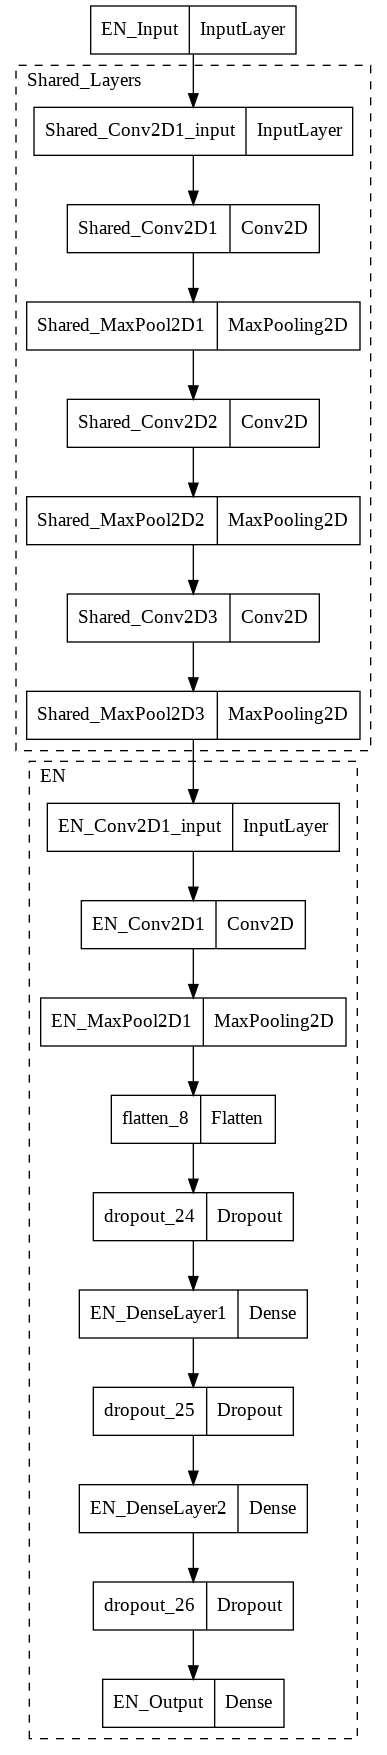

In [97]:
inputEN = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='EN_Input')
inputES = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='ES_Input')
inputFR = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='FR_Input')
inputDE = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='DE_Input')

shared = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(9,9), strides=(2,2), padding='same', activation=activations.relu, name='Shared_Conv2D1'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D1'),
    layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D2'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D2'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D3'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D3')
    ],
    name='Shared_Layers'
)

sharedLayersEN = shared(inputEN)
sharedLayersES = shared(inputES)
sharedLayersFR = shared(inputFR)
sharedLayersDE = shared(inputDE)

layersEN = languagelayers(NUM_LABELS_EN,'EN')(sharedLayersEN)
layersES = languagelayers(NUM_LABELS_ES,'ES')(sharedLayersES)
layersFR = languagelayers(NUM_LABELS_FR,'FR')(sharedLayersFR)
layersDE = languagelayers(NUM_LABELS_DE,'DE')(sharedLayersDE)


modelFullEN = tf.keras.Model(
    inputs=[inputEN],
    outputs=[layersEN],
    name='Full_Model_EN'
)


modelFullEN.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullEN, expand_nested=True)

In [98]:
modelFullEN.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [99]:
RUN = '1'

ext = '-FULL-EN'

training_callbackFULLEN = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [100]:
# model.predict(testdatasetEN)

In [101]:
historyEN = modelFullEN.fit(
    x = traindatasetEN,
    validation_data = valdatasetEN,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLEN,earlystopping_callback,reduce_lr_callback],
    verbose=1
)


Epoch 1/75
39/45 [=========================>....] - ETA: 0s - loss: 2.7253 - Categorical_Accuracy: 0.0964 - AUC: 0.5353WARNING:tensorflow:6 out of the last 39 calls to <function Model.make_test_function.<locals>.test_function at 0x7f5feee353b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


45/45 [==============================] - 2s 25ms/step - loss: 2.7239 - Categorical_Accuracy: 0.0951 - AUC: 0.5347 - val_loss: 2.6912 - val_Categorical_Accuracy: 0.0460 - val_AUC: 0.5540 - lr: 1.0000e-04
Epoch 2/75
45/45 [==============================] - 0s 9ms/step - loss: 2.6954 - Categorical_Accuracy: 0.0942 - AUC: 0.5559 - val_loss: 2.6922 - val_Categorical_Accuracy: 0.0500 - val_AUC: 0.5456 - lr: 1.0000e-04
Epoch 3/75
45/45 [==============================] - 1s 9ms/step - loss: 2.6796 - Categorical_Accuracy: 0.1022 - AUC: 0.5683 - val_loss: 2.6790 - val_Categorical_Accuracy: 0.0760 - val_AUC: 0.5629 - lr: 1.0000e-04
Epoch 4/75
45/45 [==============================] - 1s 9ms/step - loss: 2.6816 - Categorical_Accuracy: 0.0951 - AUC: 0.5611 - val_loss: 2.6797 - val_Categorical_Accuracy: 0.1100 - val_AUC: 0.5595 - lr: 1.0000e-04
Epoch 5/75
45/45 [==============================] - 1s 9ms/step - loss: 2.6743 - Categorical_Accuracy: 0.1004 - AUC: 0.5687 - val_loss: 2.6784 - val_Categoric

In [102]:
# print(modelFullEN.layers[-2].weights)

Model: "Full_Model_ES"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ES_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

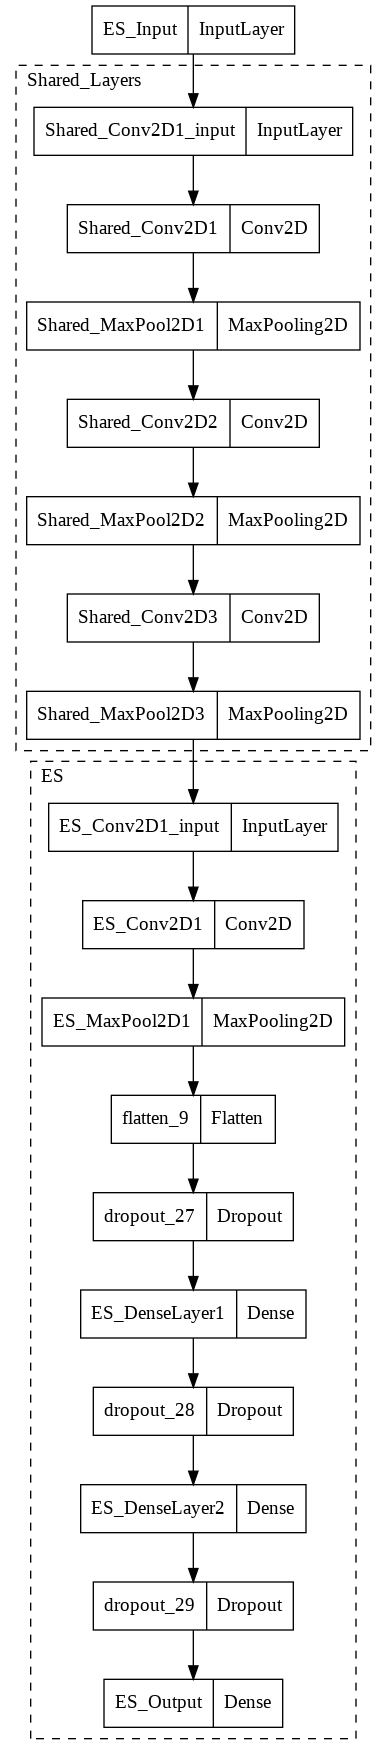

In [103]:
modelFullES = tf.keras.Model(
    inputs=[inputES],
    outputs=[layersES],
    name='Full_Model_ES'
)

modelFullES.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullES, expand_nested=True)

In [104]:
modelFullES.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [105]:
# print(modelFullES.layers[-2].weights)

In [106]:
ext = '-FULL-ES'
training_callbackFULLES = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyES = modelFullES.fit(
    x = traindatasetES,
    validation_data = valdatasetES,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLES,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
45/45 [==============================] - 2s 24ms/step - loss: 2.4603 - Categorical_Accuracy: 0.0711 - AUC: 0.4998 - val_loss: 2.4463 - val_Categorical_Accuracy: 0.0580 - val_AUC: 0.5359 - lr: 1.0000e-04
Epoch 2/75
45/45 [==============================] - 0s 9ms/step - loss: 2.4311 - Categorical_Accuracy: 0.0853 - AUC: 0.5186 - val_loss: 2.4405 - val_Categorical_Accuracy: 0.0680 - val_AUC: 0.5420 - lr: 1.0000e-04
Epoch 3/75
45/45 [==============================] - 1s 9ms/step - loss: 2.4270 - Categorical_Accuracy: 0.0764 - AUC: 0.5312 - val_loss: 2.4343 - val_Categorical_Accuracy: 0.0640 - val_AUC: 0.5722 - lr: 1.0000e-04
Epoch 4/75
45/45 [==============================] - 1s 9ms/step - loss: 2.4224 - Categorical_Accuracy: 0.0800 - AUC: 0.5369 - val_loss: 2.4256 - val_Categorical_Accuracy: 0.1180 - val_AUC: 0.5821 - lr: 1.0000e-04
Epoch 5/75
45/45 [==============================] - 1s 9ms/step - loss: 2.4240 - Categorical_Accuracy: 0.0809 - AUC: 0.5340 - val_loss: 2.4255 - va

Model: "Full_Model_FR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FR_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

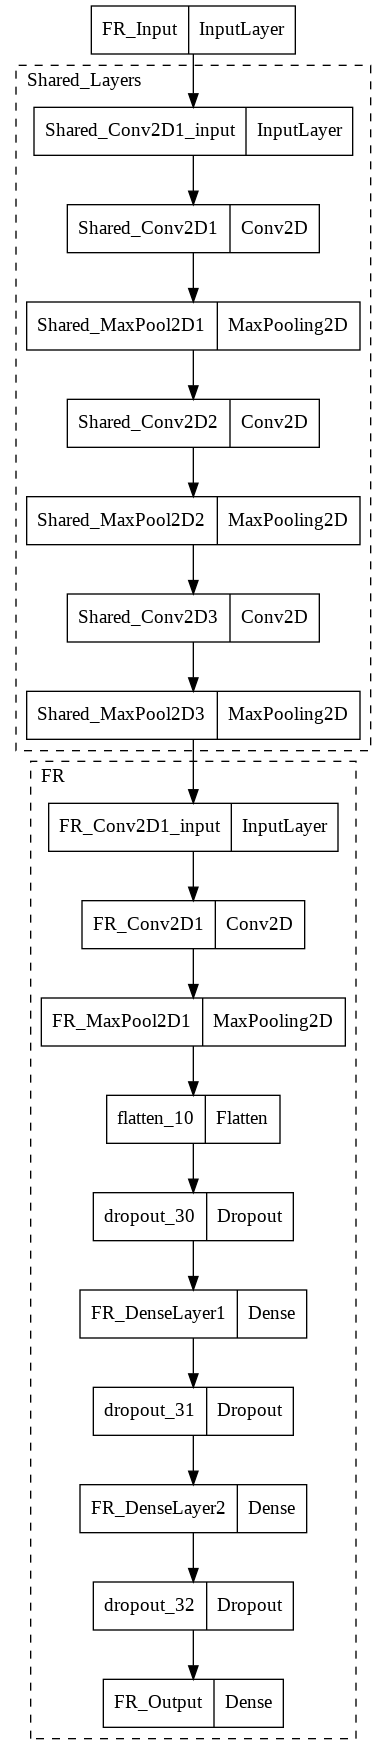

In [107]:
modelFullFR = tf.keras.Model(
    inputs=[inputFR],
    outputs=[layersFR],
    name='Full_Model_FR'
)

modelFullFR.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullFR, expand_nested=True)

In [108]:
modelFullFR.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [109]:
ext = '-FULL-FR'
training_callbackFULLFR = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyFR = modelFullFR.fit(
    x = traindatasetFR,
    validation_data = valdatasetFR,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLFR,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
45/45 [==============================] - 2s 24ms/step - loss: 2.8405 - Categorical_Accuracy: 0.0720 - AUC: 0.5113 - val_loss: 2.6734 - val_Categorical_Accuracy: 0.1380 - val_AUC: 0.6111 - lr: 1.0000e-04
Epoch 2/75
45/45 [==============================] - 0s 9ms/step - loss: 2.6856 - Categorical_Accuracy: 0.0916 - AUC: 0.5638 - val_loss: 2.6495 - val_Categorical_Accuracy: 0.1500 - val_AUC: 0.6738 - lr: 1.0000e-04
Epoch 3/75
45/45 [==============================] - 1s 9ms/step - loss: 2.6429 - Categorical_Accuracy: 0.1173 - AUC: 0.6013 - val_loss: 2.6015 - val_Categorical_Accuracy: 0.1900 - val_AUC: 0.7105 - lr: 1.0000e-04
Epoch 4/75
45/45 [==============================] - 1s 9ms/step - loss: 2.6208 - Categorical_Accuracy: 0.1271 - AUC: 0.6161 - val_loss: 2.5692 - val_Categorical_Accuracy: 0.2120 - val_AUC: 0.7490 - lr: 1.0000e-04
Epoch 5/75
45/45 [==============================] - 1s 9ms/step - loss: 2.5738 - Categorical_Accuracy: 0.1413 - AUC: 0.6444 - val_loss: 2.4988 - va

Model: "Full_Model_DE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DE_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

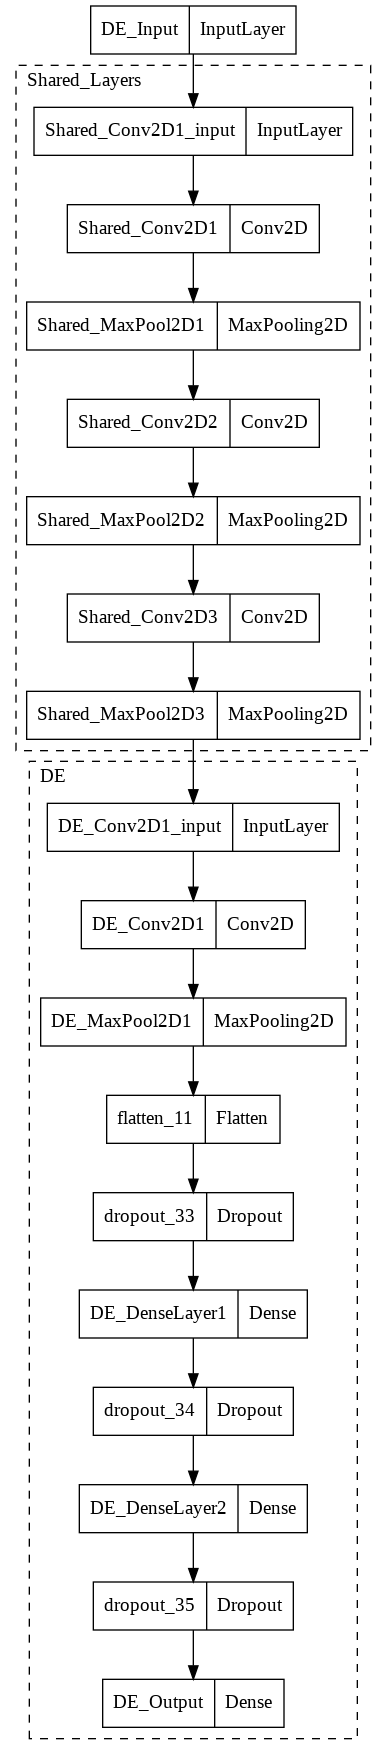

In [110]:
modelFullDE = tf.keras.Model(
    inputs=[inputDE],
    outputs=[layersDE],
    name='Full_Model_DE'
)

modelFullDE.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullDE, expand_nested=True)

In [111]:
modelFullDE.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [112]:
ext = '-FULL-DE'
training_callbackFULLDE = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyDE = modelFullDE.fit(
    x = traindatasetDE,
    validation_data = valdatasetDE,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLDE,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
45/45 [==============================] - 2s 24ms/step - loss: 2.9217 - Categorical_Accuracy: 0.0684 - AUC: 0.5163 - val_loss: 2.6836 - val_Categorical_Accuracy: 0.1280 - val_AUC: 0.5867 - lr: 1.0000e-04
Epoch 2/75
45/45 [==============================] - 0s 9ms/step - loss: 2.7167 - Categorical_Accuracy: 0.0907 - AUC: 0.5464 - val_loss: 2.6602 - val_Categorical_Accuracy: 0.1580 - val_AUC: 0.6549 - lr: 1.0000e-04
Epoch 3/75
45/45 [==============================] - 1s 9ms/step - loss: 2.6743 - Categorical_Accuracy: 0.0907 - AUC: 0.5836 - val_loss: 2.6080 - val_Categorical_Accuracy: 0.2320 - val_AUC: 0.7203 - lr: 1.0000e-04
Epoch 4/75
45/45 [==============================] - 1s 9ms/step - loss: 2.6507 - Categorical_Accuracy: 0.1111 - AUC: 0.6025 - val_loss: 2.5878 - val_Categorical_Accuracy: 0.2140 - val_AUC: 0.7348 - lr: 1.0000e-04
Epoch 5/75
45/45 [==============================] - 1s 9ms/step - loss: 2.5916 - Categorical_Accuracy: 0.1262 - AUC: 0.6465 - val_loss: 2.5052 - va

In [113]:
shared.trainable = False

In [114]:
newSharedLayers = shared(inputEN)
newLayersEN = languagelayers(NUM_LABELS_EN,'EN')(newSharedLayers)

modelENRetrain = tf.keras.Model(
    inputs=inputEN,
    outputs=newLayersEN,
    name='ENModelRetrained'
)

In [115]:
modelENRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

# modelEN.evaluate(testdatasetEN)

In [116]:
ext = '-RETRAIN-EN'
training_callbackRETRAINEN = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyENRetrain = modelENRetrain.fit(
    x = traindatasetEN,
    validation_data = valdatasetEN,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINEN,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
45/45 [==============================] - 2s 16ms/step - loss: 3.1543 - Categorical Accuracy: 0.0791 - AUC: 0.5226 - val_loss: 2.6099 - val_Categorical Accuracy: 0.1840 - val_AUC: 0.6779 - lr: 1.0000e-04
Epoch 2/75
45/45 [==============================] - 0s 7ms/step - loss: 2.7540 - Categorical Accuracy: 0.1013 - AUC: 0.5781 - val_loss: 2.5756 - val_Categorical Accuracy: 0.2620 - val_AUC: 0.7330 - lr: 1.0000e-04
Epoch 3/75
45/45 [==============================] - 1s 7ms/step - loss: 2.6639 - Categorical Accuracy: 0.1342 - AUC: 0.6046 - val_loss: 2.5333 - val_Categorical Accuracy: 0.2900 - val_AUC: 0.7752 - lr: 1.0000e-04
Epoch 4/75
45/45 [==============================] - 1s 7ms/step - loss: 2.5846 - Categorical Accuracy: 0.1449 - AUC: 0.6401 - val_loss: 2.4659 - val_Categorical Accuracy: 0.3200 - val_AUC: 0.8154 - lr: 1.0000e-04
Epoch 5/75
45/45 [==============================] - 1s 7ms/step - loss: 2.4930 - Categorical Accuracy: 0.1680 - AUC: 0.6828 - val_loss: 2.3806 - va

In [117]:
# print(modelENRetrain.layers[-2].weights)

In [118]:
newSharedLayers = shared(inputES)
newLayersES = languagelayers(NUM_LABELS_ES,'ES')(newSharedLayers)

modelESRetrain = tf.keras.Model(
    inputs=inputES,
    outputs=newLayersES,
    name='ESModelRetrained'
)

modelESRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

ext = '-RETRAIN-ES'
training_callbackRETRAINES = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyESRetrain = modelESRetrain.fit(
    x = traindatasetES,
    validation_data = valdatasetES,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINES,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
45/45 [==============================] - 2s 15ms/step - loss: 2.8656 - Categorical Accuracy: 0.1102 - AUC: 0.5410 - val_loss: 2.3294 - val_Categorical Accuracy: 0.2100 - val_AUC: 0.6924 - lr: 1.0000e-04
Epoch 2/75
45/45 [==============================] - 0s 7ms/step - loss: 2.4365 - Categorical Accuracy: 0.1191 - AUC: 0.6004 - val_loss: 2.3038 - val_Categorical Accuracy: 0.2580 - val_AUC: 0.7555 - lr: 1.0000e-04
Epoch 3/75
45/45 [==============================] - 1s 7ms/step - loss: 2.3709 - Categorical Accuracy: 0.1209 - AUC: 0.6175 - val_loss: 2.2648 - val_Categorical Accuracy: 0.2780 - val_AUC: 0.8073 - lr: 1.0000e-04
Epoch 4/75
45/45 [==============================] - 1s 7ms/step - loss: 2.3358 - Categorical Accuracy: 0.1333 - AUC: 0.6298 - val_loss: 2.2188 - val_Categorical Accuracy: 0.2880 - val_AUC: 0.8247 - lr: 1.0000e-04
Epoch 5/75
45/45 [==============================] - 1s 7ms/step - loss: 2.2397 - Categorical Accuracy: 0.1662 - AUC: 0.6768 - val_loss: 2.1429 - va

In [119]:
newSharedLayers = shared(inputFR)
newLayersFR = languagelayers(NUM_LABELS_FR,'FR')(newSharedLayers)

modelFRRetrain = tf.keras.Model(
    inputs=inputFR,
    outputs=newLayersFR,
    name='FRModelRetrained'
)

modelFRRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

ext = '-RETRAIN-FR'
training_callbackRETRAINFR = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyFRRetrain = modelFRRetrain.fit(
    x = traindatasetFR,
    validation_data = valdatasetFR,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINFR,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
45/45 [==============================] - 2s 15ms/step - loss: 2.9494 - Categorical Accuracy: 0.1049 - AUC: 0.5658 - val_loss: 2.6283 - val_Categorical Accuracy: 0.1480 - val_AUC: 0.6555 - lr: 1.0000e-04
Epoch 2/75
45/45 [==============================] - 0s 7ms/step - loss: 2.7338 - Categorical Accuracy: 0.0889 - AUC: 0.5886 - val_loss: 2.5956 - val_Categorical Accuracy: 0.2420 - val_AUC: 0.7197 - lr: 1.0000e-04
Epoch 3/75
45/45 [==============================] - 1s 7ms/step - loss: 2.6270 - Categorical Accuracy: 0.1182 - AUC: 0.6247 - val_loss: 2.5408 - val_Categorical Accuracy: 0.3260 - val_AUC: 0.7699 - lr: 1.0000e-04
Epoch 4/75
45/45 [==============================] - 1s 7ms/step - loss: 2.5818 - Categorical Accuracy: 0.1449 - AUC: 0.6431 - val_loss: 2.4954 - val_Categorical Accuracy: 0.3320 - val_AUC: 0.7820 - lr: 1.0000e-04
Epoch 5/75
45/45 [==============================] - 1s 7ms/step - loss: 2.4949 - Categorical Accuracy: 0.1698 - AUC: 0.6862 - val_loss: 2.4207 - va

In [120]:
newSharedLayers = shared(inputDE)
newLayersDE = languagelayers(NUM_LABELS_DE,'DE')(newSharedLayers)

modelDERetrain = tf.keras.Model(
    inputs=inputDE,
    outputs=newLayersDE,
    name='DEModelRetrained'
)

modelDERetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

ext = '-RETRAIN-DE'
training_callbackRETRAINDE = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyDERetrain = modelDERetrain.fit(
    x = traindatasetDE,
    validation_data = valdatasetDE,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINDE,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
45/45 [==============================] - 2s 15ms/step - loss: 3.3299 - Categorical Accuracy: 0.0684 - AUC: 0.5024 - val_loss: 2.6911 - val_Categorical Accuracy: 0.0820 - val_AUC: 0.5613 - lr: 1.0000e-04
Epoch 2/75
45/45 [==============================] - 0s 7ms/step - loss: 2.8080 - Categorical Accuracy: 0.0809 - AUC: 0.5574 - val_loss: 2.6271 - val_Categorical Accuracy: 0.1560 - val_AUC: 0.6869 - lr: 1.0000e-04
Epoch 3/75
45/45 [==============================] - 1s 7ms/step - loss: 2.6909 - Categorical Accuracy: 0.0996 - AUC: 0.5928 - val_loss: 2.5895 - val_Categorical Accuracy: 0.2680 - val_AUC: 0.7551 - lr: 1.0000e-04
Epoch 4/75
45/45 [==============================] - 1s 7ms/step - loss: 2.5877 - Categorical Accuracy: 0.1440 - AUC: 0.6450 - val_loss: 2.5198 - val_Categorical Accuracy: 0.3500 - val_AUC: 0.8154 - lr: 1.0000e-04
Epoch 5/75
45/45 [==============================] - 1s 7ms/step - loss: 2.4989 - Categorical Accuracy: 0.1680 - AUC: 0.6865 - val_loss: 2.4432 - va

In [121]:
modelENRetrain.evaluate(testdatasetEN)

250/250 [==============================] - 4s 4ms/step - loss: 0.8145 - Categorical Accuracy: 0.7480 - AUC: 0.9724


[0.8145021200180054, 0.7480000257492065, 0.9724000692367554]

In [122]:
modelESRetrain.evaluate(testdatasetES)

250/250 [==============================] - 1s 4ms/step - loss: 0.8052 - Categorical Accuracy: 0.6680 - AUC: 0.9686


[0.805233895778656, 0.6679999828338623, 0.9686190485954285]

In [123]:
modelFRRetrain.evaluate(testdatasetFR)

250/250 [==============================] - 1s 4ms/step - loss: 0.8162 - Categorical Accuracy: 0.7480 - AUC: 0.9731


[0.8162165284156799, 0.7480000257492065, 0.9731148481369019]

In [124]:
modelDERetrain.evaluate(testdatasetDE)

250/250 [==============================] - 1s 4ms/step - loss: 0.9161 - Categorical Accuracy: 0.6960 - AUC: 0.9679


[0.9160652756690979, 0.6959999799728394, 0.9678525924682617]

In [133]:
# !rm /content/savedmodels.zip
# !mkdir savedmodels

In [134]:
shared.save('savedmodels/sharedmodel')
modelFullEN.save('savedmodels/fullmodelEN')
modelFullES.save('savedmodels/fullmodelES')
modelFullFR.save('savedmodels/fullmodelFR')
modelFullDE.save('savedmodels/fullmodelDE')
modelENRetrain.save('savedmodels/modelENRetrain')
modelESRetrain.save('savedmodels/modelESRetrain')
modelFRRetrain.save('savedmodels/modelFRRetrain')
modelDERetrain.save('savedmodels/modelDERetrain')

INFO:tensorflow:Assets written to: savedmodels/sharedmodel/assets


INFO:tensorflow:Assets written to: savedmodels/sharedmodel/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelEN/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelEN/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelES/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelES/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelFR/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelFR/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelDE/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelDE/assets


INFO:tensorflow:Assets written to: savedmodels/modelENRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelENRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelESRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelESRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelFRRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelFRRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelDERetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelDERetrain/assets


In [135]:
# !zip -r /content/savedmodels.zip /content/savedmodels
#

  adding: content/savedmodels/ (stored 0%)
  adding: content/savedmodels/fullmodelEN/ (stored 0%)
  adding: content/savedmodels/fullmodelEN/keras_metadata.pb (deflated 94%)
  adding: content/savedmodels/fullmodelEN/variables/ (stored 0%)
  adding: content/savedmodels/fullmodelEN/variables/variables.index (deflated 68%)
  adding: content/savedmodels/fullmodelEN/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/savedmodels/fullmodelEN/saved_model.pb (deflated 89%)
  adding: content/savedmodels/fullmodelEN/assets/ (stored 0%)
  adding: content/savedmodels/sharedmodel/ (stored 0%)
  adding: content/savedmodels/sharedmodel/keras_metadata.pb (deflated 92%)
  adding: content/savedmodels/sharedmodel/variables/ (stored 0%)
  adding: content/savedmodels/sharedmodel/variables/variables.index (deflated 46%)
  adding: content/savedmodels/sharedmodel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/savedmodels/sharedmodel/saved_model.pb (deflated 90%)
  a

In [136]:
# from google.colab import files
# files.download('/content/savedmodels.zip')
#

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [129]:
# # %reload_ext tensorboard
# # %tensorboard --logdir logs
#

In [137]:
# !rm logs.zip
# !zip -r /content/logs.zip /content/logs
#

  adding: content/logs/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/train/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/train/events.out.tfevents.1638885579.1c7311aafe56.85.24.v2 (deflated 86%)
  adding: content/logs/model1-1-RETRAIN-EN/validation/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/validation/events.out.tfevents.1638885581.1c7311aafe56.85.25.v2 (deflated 80%)
  adding: content/logs/model1-1-RETRAIN-ES/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-ES/train/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-ES/train/events.out.tfevents.1638885622.1c7311aafe56.85.26.v2 (deflated 86%)
  adding: content/logs/model1-1-RETRAIN-ES/validation/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-ES/validation/events.out.tfevents.1638885623.1c7311aafe56.85.27.v2 (deflated 80%)
  adding: content/logs/model1-1-RETRAIN-FR/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-FR/train/ (stored 0%

In [138]:
# from google.colab import files
# files.download('/content/logs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>